In [7]:
#This part of code, the goal is to go from mapping and county level weather data to to subgroup data
# Define paths
data_and_output_dir = '/Users/ansonkong/Downloads/Data for nyu work/'
full_future_data_path = '/Users/ansonkong/Downloads/rcp85hotter/'
full_historical_data_path = '/Users/ansonkong/Downloads/historic/'

#this just smooth out operation
cutoff_year=2020 #The year prediction dataset start
start_year=2000 #The year historical 
end_year=2100

#Debug mode(only output once)
debug=False

In [53]:
#import require file
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import os
from datetime import datetime
from glob import glob

ba_dir = data_and_output_dir+'Input/EIA 930/BA/'


# Function to read and merge CSVs from a directory
def read_and_merge_csvs(directory, cols):
    combined_df = pd.DataFrame()
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(directory, file), usecols=cols)
            combined_df = pd.concat([combined_df, df], ignore_index=True)
    return combined_df

ba_cols = ['UTC Time at End of Hour', 'Balancing Authority', 'Demand (MW)']
ba_combined_df = read_and_merge_csvs(ba_dir, ba_cols)



#Path, this will update itself
mapping_path = data_and_output_dir + 'output/merged_rb_control_area_mapping.csv'
future_population_data_path = data_and_output_dir + 'input/Electric_Retail_Service_Territories/ssp3_county_population.csv'
historical_population_data_path = data_and_output_dir + 'input/county_populations_2000_to_2020.csv'
output_path = data_and_output_dir + 'output/'

# Load mapping and population data
mapping_df = pd.read_csv(mapping_path)
future_population_df = pd.read_csv(future_population_data_path)
historical_population_df = pd.read_csv(historical_population_data_path)

#crate looping for interp
years = np.arange(cutoff_year, end_year + 1, 10)
interp_years = np.arange(cutoff_year, end_year + 1)

# Ensure FIPS codes are five zero-padded strings
historical_population_df['FIPS'] = historical_population_df['county_FIPS'].astype(str).str.zfill(5)
future_population_df['FIPS'] = future_population_df['FIPS'].astype(str).str.zfill(5)
mapping_df['GEOID'] = mapping_df['GEOID'].astype(str).str.zfill(5)

# Rename 'pop_{year}' columns to just '{year}'
for year in range(start_year, cutoff_year+1):
    if f'pop_{year}' in historical_population_df.columns:
        historical_population_df.rename(columns={f'pop_{year}': str(year)}, inplace=True)



# Assuming 'FIPS' is the column to join on and 'Year' is the column indicating the year in future_population_df
for index, row in future_population_df.iterrows():
    pop_values = [row[str(year)] for year in years if str(year) in row]
    interpolator = interp1d(years, pop_values, kind='linear', fill_value="extrapolate")
    interpolated_values = interpolator(interp_years)
    for year in interp_years:
        future_population_df.at[index, str(year)] = interpolated_values[year - cutoff_year]


# Select relevant columns for historical data
historical_population_df = historical_population_df[['FIPS'] + [str(year) for year in range(start_year, cutoff_year)]]

# Select relevant columns for future data
future_population_df = future_population_df[['FIPS'] + [str(year) for year in interp_years]]

# Concatenate historical and future dataframes
combined_population_df = pd.merge(historical_population_df, future_population_df, on='FIPS', how='outer')
# Merge combined population data with mapping data
# Assuming 'GEOID' in mapping_df corresponds to 'FIPS' in population data
combined_df = pd.merge(mapping_df, combined_population_df, left_on='GEOID', right_on='FIPS', how='inner')
combined_df['FIPS']=combined_df['GEOID']

/var/folders/8v/68yqll_54lzgb57b5q8_fbrc0000gn/T/ipykernel_7172/2308327632.py:17: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(directory, file), usecols=cols)
/var/folders/8v/68yqll_54lzgb57b5q8_fbrc0000gn/T/ipykernel_7172/2308327632.py:17: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(directory, file), usecols=cols)
/var/folders/8v/68yqll_54lzgb57b5q8_fbrc0000gn/T/ipykernel_7172/2308327632.py:17: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(directory, file), usecols=cols)
/var/folders/8v/68yqll_54lzgb57b5q8_fbrc0000gn/T/ipykernel_7172/2308327632.py:17: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(directory, file), usecols=cols)
/var/folders/8v/

In [54]:
combined_df['FIPS']=combined_df['FIPS_x']
combined_df=combined_df[['FIPS','rb','geometry']+[str(year) for year in range(start_year, end_year+1)]]

In [72]:
# Generate the expected set of 'rb' values ('p1' to 'p134')
expected_rbs = {'p' + str(i) for i in range(1, 135)}

# Extract the unique 'rb' values from combined_df
actual_rbs = set(combined_df['rb'].unique())

# Check if combined_df['rb'] contains all values from 'p1' to 'p134'
missing_rbs = expected_rbs - actual_rbs
extra_rbs = actual_rbs - expected_rbs

# Display the results
if not missing_rbs:
    print("All 'rb' values from 'p1' to 'p134' are present in combined_df.")
else:
    print(f"Missing 'rb' values in combined_df: {missing_rbs}")

if extra_rbs:
    print(f"Extra 'rb' values in combined_df not in the range 'p1' to 'p134': {extra_rbs}")


All 'rb' values from 'p1' to 'p134' are present in combined_df.


In [58]:
rb_to_ba=pd.read_csv(data_and_output_dir + 'output/rb_to_ba.csv')
rb_to_ba

,rb,geometry,BA_Code
0,p1,MULTIPOLYGON (((-13687924.23979998 5965691.031...,BPAT
1,p10,MULTIPOLYGON (((-13179969.92729995 3871459.308...,CISO
2,p100,MULTIPOLYGON (((-8663603.907299994 4741636.251...,PJM
3,p101,MULTIPOLYGON (((-9090644.388599997 2824968.523...,SEC
4,p102,MULTIPOLYGON (((-8924334.972400004 2980193.438...,FPL
...,...,...,...
129,p95,MULTIPOLYGON (((-9114960.995699998 4188937.632...,DUK
130,p96,MULTIPOLYGON (((-8956515.669899996 3812869.837...,SC
131,p97,MULTIPOLYGON (((-8873816.772200003 4375448.743...,DUK
132,p98,MULTIPOLYGON (((-8678230.449399997 4014627.318...,CPLE


In [59]:
rb_to_ba['BA_Code'].unique()

array(['BPAT', 'CISO', 'PJM', 'SEC', 'FPL', 'MISO', 'NEVP', 'NYIS',
       'ISNE', 'WALC', 'AVA', 'IPCO', 'PACE', 'NWMT', 'SWPP', 'WACM',
       'AZPS', 'PNM', 'PSCO', 'AECI', 'EPE', 'PACW', 'ERCO', 'TVA',
       'SOCO', 'AEC', 'DUK', 'SC', 'CPLE'], dtype=object)

In [73]:
population_with_county_and_rb_df = pd.merge(combined_df, rb_to_ba, on='rb', how='left')

In [74]:
# Extract the unique 'rb' values from combined_df
actual_rbs = set(population_with_county_and_rb_df ['rb'].unique())

# Check if combined_df['rb'] contains all values from 'p1' to 'p134'
missing_rbs = expected_rbs - actual_rbs
extra_rbs = actual_rbs - expected_rbs

# Display the results
if not missing_rbs:
    print("All 'rb' values from 'p1' to 'p134' are present in combined_df.")
else:
    print(f"Missing 'rb' values in combined_df: {missing_rbs}")

if extra_rbs:
    print(f"Extra 'rb' values in combined_df not in the range 'p1' to 'p134': {extra_rbs}")


All 'rb' values from 'p1' to 'p134' are present in combined_df.


In [92]:
# Assuming 'population_with_county_and_rb_df' is your DataFrame and it's already loaded
# Define expected 'rb' values
expected_rbs = {'p' + str(i) for i in range(1, 135)}

# Extract the unique 'rb' values from population_with_county_and_rb_df
actual_rbs = set(population_with_county_and_rb_df['rb'].unique())

# Identify rows with 'Unknown' BA_Code and print their 'rb' values
unknown_ba_rbs = population_with_county_and_rb_df[population_with_county_and_rb_df['BA_Code'] == 'Unknown']['rb'].unique()
print(f"'rb' values with 'Unknown' BA_Code: {unknown_ba_rbs}")

# Check if actual_rbs contains all values from 'p1' to 'p134'
missing_rbs = expected_rbs - actual_rbs
extra_rbs = actual_rbs - expected_rbs

# Display the results for missing and extra 'rb' values
if not missing_rbs:
    print("All 'rb' values from 'p1' to 'p134' are present in population_with_county_and_rb_df.")
else:
    print(f"Missing 'rb' values in population_with_county_and_rb_df: {missing_rbs}")

if extra_rbs:
    print(f"Extra 'rb' values in population_with_county_and_rb_df not in the range 'p1' to 'p134': {extra_rbs}")


'rb' values with 'Unknown' BA_Code: []
All 'rb' values from 'p1' to 'p134' are present in population_with_county_and_rb_df.


In [66]:
# Create a list of the year columns to sum up
year_columns = [str(year) for year in range(start_year, end_year + 1)]

# Group by 'rb' and 'BA_Code', then sum up the specified year columns
aggregated_df = population_with_county_and_rb_df.groupby(['rb', 'BA_Code'])[year_columns].sum().reset_index()


In [67]:
# Loop through each year column to perform the transformation
for year in year_columns:
    # Calculate the sum for each 'rb' group in the current year column
    rb_sum = aggregated_df.groupby('BA_Code')[year].transform('sum')
    
    # Divide each value by its corresponding 'rb' total for the current year
    aggregated_df[year] = aggregated_df[year] / rb_sum

# Display the first few rows of the transformed DataFrame to verify the results
print(aggregated_df.head())


     rb BA_Code      2000      2001      2002      2003      2004      2005  \
0    p1    BPAT  0.450298  0.450676  0.449738  0.448958  0.448836  0.448224   
1   p10    CISO  0.520191  0.520019  0.521367  0.522828  0.524362  0.524909   
2  p100     PJM  0.003103  0.003143  0.003189  0.003227  0.003270  0.003331   
3  p101     SEC  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
4  p102     FPL  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

       2006      2007  ...      2091      2092      2093      2094      2095  \
0  0.448384  0.447617  ...  0.455866  0.456058  0.456253  0.456450  0.456651   
1  0.524787  0.523626  ...  0.553351  0.553587  0.553828  0.554073  0.554323   
2  0.003387  0.003424  ...  0.003885  0.003872  0.003860  0.003847  0.003834   
3  1.000000  1.000000  ...  1.000000  1.000000  1.000000  1.000000  1.000000   
4  1.000000  1.000000  ...  1.000000  1.000000  1.000000  1.000000  1.000000   

       2096      2097      2098      2099   

In [75]:
# Extract the unique 'rb' values from combined_df
actual_rbs = set(aggregated_df['rb'].unique())

# Check if combined_df['rb'] contains all values from 'p1' to 'p134'
missing_rbs = expected_rbs - actual_rbs
extra_rbs = actual_rbs - expected_rbs

# Display the results
if not missing_rbs:
    print("All 'rb' values from 'p1' to 'p134' are present in combined_df.")
else:
    print(f"Missing 'rb' values in combined_df: {missing_rbs}")

if extra_rbs:
    print(f"Extra 'rb' values in combined_df not in the range 'p1' to 'p134': {extra_rbs}")

All 'rb' values from 'p1' to 'p134' are present in combined_df.


In [93]:
# Adjusting for multiple markers of unknown 'rb' values
unknown_rb_bas = population_with_county_and_rb_df[(population_with_county_and_rb_df['rb'] == 'Unknown') | 
                                                  (population_with_county_and_rb_df['rb'].isna())]['BA_Code'].unique()

print(f"BA_Code values with unknown 'p' area: {unknown_rb_bas}")


BA_Code values with unknown 'p' area: []


In [81]:
# Assuming ba_combined_df and rb_to_ba are your DataFrames

# Extract unique 'Balancing Authority' and 'BA_Code' values
unique_ba_combined = set(ba_combined_df['Balancing Authority'].unique())
unique_rb_to_ba = set(rb_to_ba['BA_Code'].unique())

# Find codes that are unique to ba_combined_df
unique_to_ba_combined = unique_ba_combined - unique_rb_to_ba

# Find codes that are unique to rb_to_ba
unique_to_rb_to_ba = unique_rb_to_ba - unique_ba_combined

# Find codes that are present in both
perfect_matches = unique_ba_combined.intersection(unique_rb_to_ba)

# Display the results
print(f"Codes unique to ba_combined_df: {unique_to_ba_combined}")
print(f"Codes unique to rb_to_ba: {unique_to_rb_to_ba}")
print(f"Perfect matches: {perfect_matches}")


Codes unique to ba_combined_df: {'AVRN', 'SPA', 'GLHB', 'NSB', 'FMPP', 'HGMA', 'GRID', 'GRMA', 'DOPD', 'GVL', 'WWA', 'TAL', 'WAUW', 'IID', 'DEAA', 'SCL', 'TEPC', 'LGEE', 'GWA', 'SEPA', 'YAD', 'GCPD', 'EEI', 'JEA', 'PSEI', 'CPLW', 'FPC', 'SRP', 'LDWP', 'TIDC', 'OVEC', 'WAUE', 'CHPD', 'TEC', 'BANC', 'PGE', 'SCEG', 'TPWR', 'GRIF', 'HST'}
Codes unique to rb_to_ba: set()
Perfect matches: {'SWPP', 'SOCO', 'SC', 'PNM', 'FPL', 'IPCO', 'AEC', 'CPLE', 'AZPS', 'ERCO', 'MISO', 'PJM', 'TVA', 'BPAT', 'NWMT', 'EPE', 'NYIS', 'PACW', 'AVA', 'WALC', 'CISO', 'AECI', 'DUK', 'WACM', 'PACE', 'SEC', 'ISNE', 'NEVP', 'PSCO'}


In [85]:
csv_path = data_and_output_dir + 'Input/ba_service_territory_2020.csv'
# Read the CSV file
df = pd.read_csv(csv_path)
df['BA_Code'].unique()

array(['NBSO', 'AEC', 'AMPL', 'AZPS', 'AECI', 'BPAT', 'CISO', 'CPLE',
       'CHPD', 'CEA', 'DOPD', 'DUK', 'EPE', 'ERCO', 'FPL', 'FPC', 'GVL',
       'HST', 'IPCO', 'IID', 'JEA', 'LDWP', 'LGEE', 'NWMT', 'NEVP',
       'ISNE', 'NSB', 'NYIS', 'OVEC', 'PACW', 'PACE', 'FMPP', 'GCPD',
       'PJM', 'PGE', 'PSCO', 'PNM', 'PSEI', 'BANC', 'SRP', 'SCL', 'SCEG',
       'SC', 'SPA', 'SOCO', 'TPWR', 'TAL', 'TEC', 'TVA', 'TIDC', 'HECO',
       'WAUW', 'AVA', 'SEC', 'TEPC', 'WALC', 'WACM', 'SEPA', 'MISO',
       'SWPP'], dtype=object)

In [106]:

import pandas as pd

# Assuming ba_combined_df and aggregated_df are already loaded

# Define your BA to rb mapping
ba_to_rb_mapping = {
    # Combined both dictionaries for simplicity
    "LDWP": "p10", "GCPD": "p109", "LGEE": ["p109", "p108"], "PGE": "p5", "SRP": "p28",
    "TEC": "p101", "OVEC": "p112", "TAL": "p101", "BANC": "p9", "PSEI": "p1",
    "SCL": "p1", "NBSO": "p34", "FPC": "p101", "NSB": "p101", "HST": "p102",
    "SEPA": "p94", "SCEG": "p96", "GVL": "p101", "IID": "p10", "TIDC": "p9",
    # Problematic mappings as fallback
    "WAUM": "p20", "SPA": "p84", "TEPC": "p27", "TPWR": "p1", "DOPD": "p3",
    "JEA": "p3", "FMPP": "p102", "CHPD": "p1",'CPLW':'p56','WAUW':'p18'
}

ba_that_produce_only={'AVRN',
 'DEAA',
 'GLHB',
 'GRID',
 'GRIF',
 'GRMA',
 'GWA',
 'HGMA',
 'WWA',
 'YAD'}

results = []
unknown_set=set()

for index, row in ba_combined_df.iterrows():
    year = pd.to_datetime(row['UTC Time at End of Hour']).year
    ba_code = row['Balancing Authority']
    
    try:
        # Ensure the demand is a float
        # Convert to string first, then replace commas and convert to float
        demand_mw_str = str(row['Demand (MW)'])
        demand_mw = float(demand_mw_str.replace(',', ''))
        
        if ba_code in aggregated_df['BA_Code'].values and str(year) in aggregated_df.columns:
            fraction = aggregated_df.loc[aggregated_df['BA_Code'] == ba_code, str(year)].iloc[0]
            # Ensure fraction is numeric and not NaN
            fraction = float(fraction) if not pd.isna(fraction) else 0.0
            demand = demand_mw * fraction
            rb_value=aggregated_df.loc[aggregated_df['BA_Code'] == ba_code, 'rb'].iloc[0]
        elif ba_code in ba_that_produce_only:
            continue

        else:
            rb_value = ba_to_rb_mapping.get(ba_code, 'Unknown')
            if rb_value=='Unknown':
                print(ba_code)
                unknown_set.add(ba_code)
            
            # If rb_value is a list, divide demand equally; else, use demand as is
            if isinstance(rb_value, list):
                demand = demand_mw / len(rb_value)
                for rb in rb_value:
                    results.append({'UTC Time at End of Hour': row['UTC Time at End of Hour'], 'rb': rb, 'Demand': demand})
                continue
            else:
                demand = demand_mw

        # Append results for both cases
        if not isinstance(rb_value, list):  # If rb_value was not a list, append now
            results.append({'UTC Time at End of Hour': row['UTC Time at End of Hour'], 'rb': rb_value, 'Demand': demand})

    except ValueError as e:
        # Convert the row to a string for printing; you might want to truncate or format this for readability
        row_str = ', '.join([f"{col}: {val}" for col, val in row.items()])
        print(f"Skipping row due to data issue: BA_Code {ba_code} at {row['UTC Time at End of Hour']}. Error: {e}. Row: {row_str}")


# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Aggregate results by 'UTC Time at End of Hour' and 'rb', summing the demand
aggregated_results = results_df.groupby(['UTC Time at End of Hour', 'rb'], as_index=False)['Demand'].sum()


# Save to CSV
aggregated_results.to_csv(data_and_output_dir+'output/aggregated_results.csv', index=False)


EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI
EEI


In [104]:
unknown_set

{'AVRN',
 'CPLW',
 'DEAA',
 'EEI',
 'GLHB',
 'GRID',
 'GRIF',
 'GRMA',
 'GWA',
 'HGMA',
 'WAUE',
 'WAUW',
 'WWA',
 'YAD'}

In [101]:
aggregated_results

,UTC Time at End of Hour,rb,Demand
0,01/01/2016 10:00:00 AM,Unknown,565.000000
1,01/01/2016 10:00:00 AM,p1,9350.553624
2,01/01/2016 10:00:00 AM,p10,15045.082344
3,01/01/2016 10:00:00 AM,p100,271.633057
4,01/01/2016 10:00:00 AM,p101,5826.000000
...,...,...,...
1864042,12/31/2020 9:00:00 PM,p91,453.000000
1864043,12/31/2020 9:00:00 PM,p94,0.000000
1864044,12/31/2020 9:00:00 PM,p95,2866.715070
1864045,12/31/2020 9:00:00 PM,p96,5083.000000


In [94]:
# Assuming 'aggregated_results' is your DataFrame and it's already loaded

# Filter for rows where 'rb' is marked as 'Unknown'
unknown_rb_rows = aggregated_results[aggregated_results['rb'] == 'Unknown']

# Print the filtered rows
print(unknown_rb_rows)


       UTC Time at End of Hour       rb         Demand
0       01/01/2016 10:00:00 AM  Unknown   84544.036224
16      01/01/2016 10:00:00 PM  Unknown   99744.846231
32      01/01/2016 11:00:00 AM  Unknown   84673.281862
48      01/01/2016 11:00:00 PM  Unknown  101981.315584
64      01/01/2016 12:00:00 AM  Unknown  108090.929005
...                        ...      ...            ...
753882   12/31/2020 7:00:00 PM  Unknown  101335.313941
753897   12/31/2020 8:00:00 AM  Unknown   85494.991077
753912   12/31/2020 8:00:00 PM  Unknown  100304.183622
753927   12/31/2020 9:00:00 AM  Unknown   84090.992837
753942   12/31/2020 9:00:00 PM  Unknown   99621.220772

[48268 rows x 3 columns]


/var/folders/8v/68yqll_54lzgb57b5q8_fbrc0000gn/T/ipykernel_7172/2028333157.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_rb['UTC Time at End of Hour'] = pd.to_datetime(unknown_rb['UTC Time at End of Hour'])


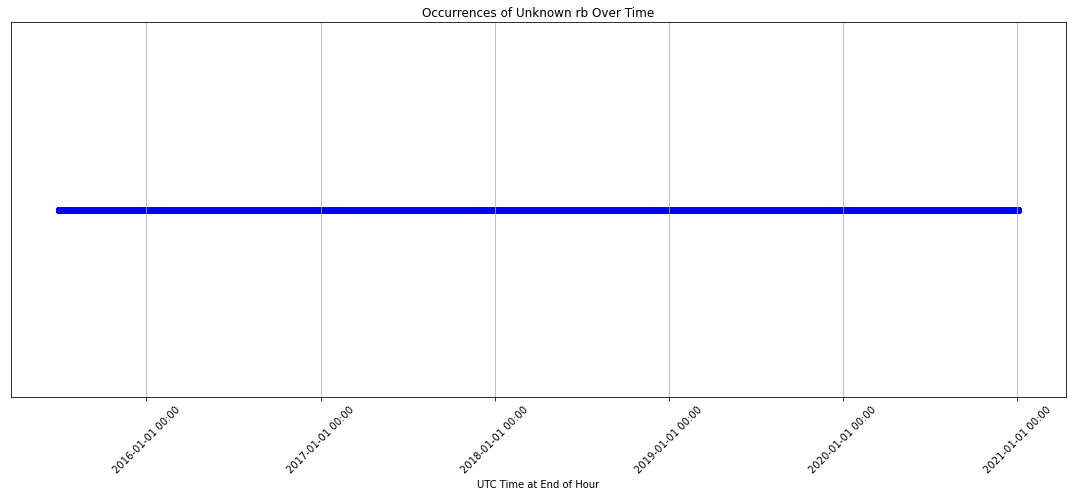

In [98]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'aggregated_results' is loaded and contains a column 'rb' with 'Unknown' to denote unknown rb values

# Filter for unknown 'rb' values
unknown_rb = aggregated_results[aggregated_results['rb'] == 'Unknown']

# Convert 'UTC Time at End of Hour' to datetime for proper sorting and grouping
unknown_rb['UTC Time at End of Hour'] = pd.to_datetime(unknown_rb['UTC Time at End of Hour'])

# Group by 'UTC Time at End of Hour' and count occurrences
grouped_unknown = unknown_rb.groupby('UTC Time at End of Hour').size()

# Ensure the index (which is 'UTC Time at End of Hour') is sorted
grouped_unknown = grouped_unknown.sort_index()

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming 'aggregated_results' is your DataFrame
aggregated_results['UTC Time at End of Hour'] = pd.to_datetime(aggregated_results['UTC Time at End of Hour'], format='%m/%d/%Y %I:%M:%S %p')

# Filter for entries with 'Unknown' rb
unknown_rb_df = aggregated_results[aggregated_results['rb'] == 'Unknown']

# Ensure the DataFrame is sorted by 'UTC Time at End of Hour'
unknown_rb_df = unknown_rb_df.sort_values('UTC Time at End of Hour')

plt.figure(figsize=(15, 7))

# For a scatter plot with all points on the same line, use a constant value for Y, e.g., 0
y_values = [0] * len(unknown_rb_df)  # Create a list of zeros with the same length as the dataframe

plt.scatter(unknown_rb_df['UTC Time at End of Hour'], y_values, color='b')

plt.title('Occurrences of Unknown rb Over Time')
plt.xlabel('UTC Time at End of Hour')
plt.gca().axes.get_yaxis().set_visible(False)  # Hide the Y-axis

# Improve datetime x-axis formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=45)
plt.grid(True, which='major', axis='x')  # Only show grid for X-axis
plt.tight_layout()
plt.show()


